In [1]:
import os
import sys
import random
import warnings
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras import optimizers
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/training_hair_skin/'
TEST_PATH = 'data/testing_images/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH + 'images/'))[2]
test_ids = next(os.walk(TEST_PATH))[2]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks...')
sys.stdout.flush()
for n, file_name in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + 'images/' + file_name
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
    id = re.search(r'(\d+)\.jpg', file_name)[1]
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask = imread(TRAIN_PATH + f"masks/train_mask_{id}.ppm")
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask[:,:,:1]

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images...')
sys.stdout.flush()
for n, file_name in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + file_name
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks...


100%|██████████| 2000/2000 [00:07<00:00, 259.33it/s]

Getting and resizing test images...



100%|██████████| 927/927 [00:02<00:00, 453.97it/s]

Done!


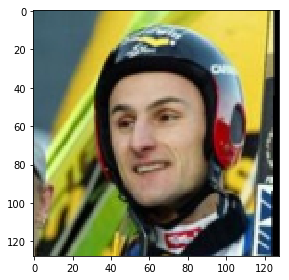

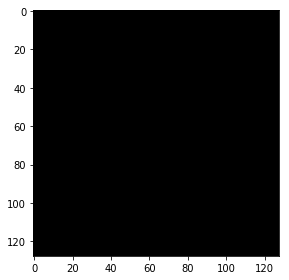

In [3]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [4]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [5]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
sgd = optimizers.SGD(lr=0.005)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
# model.summary()

In [6]:
# Fit model
earlystopper = EarlyStopping(patience=25, verbose=1)
checkpointer = ModelCheckpoint('better.h5', verbose=1, save_best_only=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=200,
                    callbacks=[earlystopper, checkpointer, reducelr])

Train on 1800 samples, validate on 200 samples
Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.2843 - mean_iou: 0.0317 - val_loss: 0.2190 - val_mean_iou: 0.0556

Epoch 00001: val_loss improved from inf to 0.21900, saving model to better.h5
Epoch 2/200
1800/1800 [==============================] - 5s 3ms/step - loss: 0.2219 - mean_iou: 0.0704 - val_loss: 0.2070 - val_mean_iou: 0.0820

Epoch 00002: val_loss improved from 0.21900 to 0.20699, saving model to better.h5
Epoch 3/200
1800/1800 [==============================] - 5s 3ms/step - loss: 0.2044 - mean_iou: 0.0888 - val_loss: 0.1928 - val_mean_iou: 0.0969

Epoch 00003: val_loss improved from 0.20699 to 0.19275, saving model to better.h5
Epoch 4/200
1800/1800 [==============================] - 5s 3ms/step - loss: 0.1858 - mean_iou: 0.1046 - val_loss: 0.1767 - val_mean_iou: 0.1113

Epoch 00004: val_loss improved from 0.19275 to 0.17667, saving model to better.h5
Epoch 5/200
1800/1800 [======================

1800/1800 [==============================] - 5s 3ms/step - loss: 0.0322 - mean_iou: 0.3488 - val_loss: 0.1253 - val_mean_iou: 0.3499

Epoch 00040: val_loss did not improve from 0.09489
Epoch 41/200
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0320 - mean_iou: 0.3509 - val_loss: 0.1257 - val_mean_iou: 0.3519

Epoch 00041: val_loss did not improve from 0.09489
Epoch 42/200
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0321 - mean_iou: 0.3528 - val_loss: 0.1261 - val_mean_iou: 0.3538

Epoch 00042: val_loss did not improve from 0.09489
Epoch 43/200
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0321 - mean_iou: 0.3547 - val_loss: 0.1259 - val_mean_iou: 0.3556

Epoch 00043: val_loss did not improve from 0.09489
Epoch 44/200
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0322 - mean_iou: 0.3564 - val_loss: 0.1262 - val_mean_iou: 0.3573

Epoch 00044: val_loss did not improve from 0.09489
Epoch 00044: early stop

In [7]:
# Predict on train, val and test
model = load_model('better.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

927/927 [==============================] - 1s 687us/step


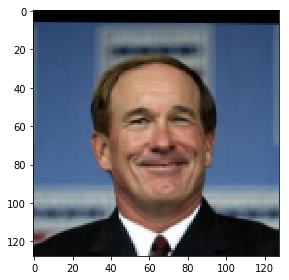

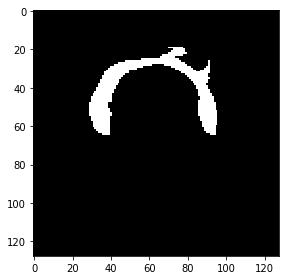

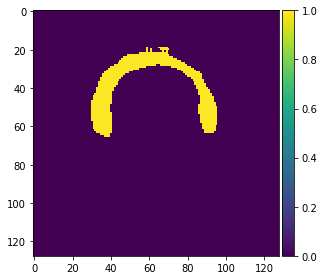

In [8]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
%matplotlib inline  

# encoding function
# based on the implementation: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python/code
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

encodings = []
for n, mask in enumerate(preds_test_upsampled):
    mask = np.round(np.array(mask)).astype(dtype=np.uint8)
    encodings.append(rle_encoding(mask))
    
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(test_ids).apply(lambda x: os.path.splitext(x)[0].replace('_img_', '_mask_'))
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('results.csv', index=False)

print("Finished writing csv.")

Finished writing csv.
